<a href="https://colab.research.google.com/github/cfong32/netflix-prize/blob/main/step3_gradient_descent_M1000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download preprocessed dataset
!wget -qO ratings_M50.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/EWqG6YIAGfpLihYVvtpMeRQB1ngfhPZPydHCoUL87QR3yA?download=1
!wget -qO ratings_M1000.csv https://uoguelphca-my.sharepoint.com/:x:/g/personal/chungyan_uoguelph_ca/ESYy4ukVKs9DkY6-YVBh-0kBr5uQE29dC1Tq0PRi_tJJhg?download=1

In [2]:
import torch
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
pd.set_option('display.min_rows', 4)

In [3]:
# read dataset into dataframe

df = (pd.read_csv('ratings_M1000.csv')
      .assign(target=lambda x: x.rating/6)
)
N = df.user.nunique()
M = df.movie.nunique()

print('num_user:', N, 'num_movie:', M)
display(df)

num_user: 157939 num_movie: 1000


,user,movie,rating,target
0,0,0,3,0.500000
1,1,0,4,0.666667
...,...,...,...,...
4088778,157540,999,1,0.166667
4088779,157856,999,4,0.666667


In [4]:
# split data into train and test sets

split = 0.8
train = df.sample(frac=split)
test  = df[~df.index.isin(train.index)]

display(train)
display(test)

,user,movie,rating,target
1087313,142507,289,3,0.500000
3771745,194,896,3,0.500000
...,...,...,...,...
2618036,45479,606,3,0.500000
3091178,80869,721,5,0.833333


,user,movie,rating,target
8,8,0,3,0.500000
9,9,0,4,0.666667
...,...,...,...,...
4088761,148691,999,2,0.333333
4088774,153088,999,3,0.500000


In [5]:
# build the matrix-multiplication-based model

class UV(nn.Module):
    def __init__(self, N, M, D):                # N: num_user, M: num_movie, D: embedding dimension
        super().__init__()
        self.U = nn.Embedding(N, D)             # matrix U, user embeddings, sized N-by-D
        self.V = nn.Embedding(M, D)             # matrix V, movie embeddings, sized M-by-D
        
    def forward(self, u_idx, m_idx):
        U = self.U(u_idx)                       # retrieve user embeddings by user indexes
        V = self.V(m_idx)                       # retrieve movie embeddings by movie indexes
        dot_products = (U*V).sum(dim=1)         # predicted ratings are their dot products
        output = torch.sigmoid(dot_products)    # map to [0,1]
        return output

In [6]:
###
# training
###

# check GPU
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# set hyperparameters
D = 10              # embedding dimension
lr = 1e-3           # learning rate
batch_size = 1_000_000
max_epoch = 10_000
patience = 10       # early stop if not improving in this num of evaluations

# initialize model and ...
model = UV(N, M, D).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# convert data to torch Tensor
train_u_idx = torch.IntTensor  (train.user.values).to(device)
train_v_idx = torch.IntTensor  (train.movie.values).to(device)
train_y     = torch.FloatTensor(train.target.values).to(device)
train_size  = len(train_u_idx)

test_u_idx  = torch.IntTensor  (test.user.values).to(device)
test_v_idx  = torch.IntTensor  (test.movie.values).to(device)
test_y      = torch.FloatTensor(test.target.values).to(device)

# train
recs = []
min_test_loss = None
for epoch in range(max_epoch):

    # gradient descent
    model.train()
    optimizer.zero_grad()

    batch_idx = torch.randperm(train_size)[:batch_size]
    train_y_hat = model(train_u_idx[batch_idx], train_v_idx[batch_idx])
    loss = loss_fn(train_y_hat, train_y[batch_idx])
    loss.backward()
    optimizer.step()

    # evaluate test loss
    if epoch % 100 == 0:
        model.eval()
        test_y_hat = model(test_u_idx, test_v_idx)
        test_loss = loss_fn(test_y_hat, test_y).item()
        rec = {
            'epoch'     : epoch,
            'train_loss': loss.item(),
            'test_loss' : test_loss,
        }
        recs.append(rec)
        print(rec)

        # check for early stopping
        if min_test_loss is None or test_loss < min_test_loss:
            min_test_loss = test_loss
            not_improving_count = 0
        else:
            not_improving_count += 1
            if not_improving_count >= patience:
                break

{'epoch': 0, 'train_loss': 0.17578303813934326, 'test_loss': 0.1754990518093109}
{'epoch': 100, 'train_loss': 0.1590600609779358, 'test_loss': 0.16514979302883148}
{'epoch': 200, 'train_loss': 0.14286984503269196, 'test_loss': 0.15395215153694153}
{'epoch': 300, 'train_loss': 0.12689287960529327, 'test_loss': 0.14208149909973145}
{'epoch': 400, 'train_loss': 0.11207062751054764, 'test_loss': 0.12990838289260864}
{'epoch': 500, 'train_loss': 0.09823478013277054, 'test_loss': 0.11788152158260345}
{'epoch': 600, 'train_loss': 0.08638273179531097, 'test_loss': 0.10647495090961456}
{'epoch': 700, 'train_loss': 0.07559318840503693, 'test_loss': 0.0960489884018898}
{'epoch': 800, 'train_loss': 0.06669198721647263, 'test_loss': 0.08679281920194626}
{'epoch': 900, 'train_loss': 0.05914510041475296, 'test_loss': 0.07872866094112396}
{'epoch': 1000, 'train_loss': 0.05317750200629234, 'test_loss': 0.07175881415605545}
{'epoch': 1100, 'train_loss': 0.04787660762667656, 'test_loss': 0.06570103764533

<Axes: xlabel='epoch'>

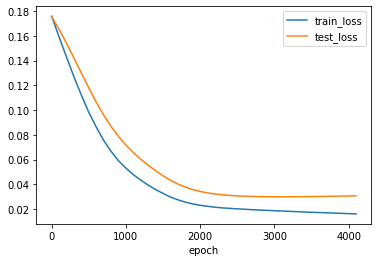

In [11]:
# training curves
pd.DataFrame(recs).set_index('epoch')[['train_loss', 'test_loss']].plot()

In [12]:
# resulted U and V
U = model.U.weight
V = model.V.weight

print('first few rows of,')
print('U:', U[:3])
print('V:', V[:3])

first few rows of,
U: tensor([[ 0.2728,  0.2293,  0.0769,  0.3855, -0.0803, -0.3820,  0.0668,  0.0579,
         -0.3730, -0.1406],
        [ 0.4365, -0.0503, -0.7972,  0.2711, -0.6343,  0.7954, -0.1674, -0.4260,
         -0.8073, -1.0485],
        [-0.5955,  0.3364,  0.2772, -0.2779, -0.5575,  0.7964, -0.2990, -0.2442,
         -0.6098, -0.2573]], device='cuda:0', grad_fn=<SliceBackward0>)
V: tensor([[-0.3117,  0.1543,  0.2874,  0.2925, -0.4034,  0.7276,  0.2524,  0.0245,
         -0.6641,  0.2477],
        [ 0.0330,  0.3795,  0.1804,  0.4484, -0.1450,  0.6317,  0.3068, -0.1655,
         -0.5120, -0.2718],
        [-0.2089,  0.0429,  0.5696,  0.0777, -0.0708,  0.5739,  0.4915, -0.0035,
         -0.2242, -0.3345]], device='cuda:0', grad_fn=<SliceBackward0>)


In [13]:
# prediction results

test_y_hat = model(test_u_idx, test_v_idx).cpu().detach().numpy()

df_res = (
    test
    .assign(target_pred    =test_y_hat,
            rating_pred    =lambda x: (x.target_pred*6).clip(1,5),  # clipped between 1 and 5
            rating_residual=lambda x: x.rating - x.rating_pred)
)

df_res.sample(10)

,user,movie,rating,target,target_pred,rating_pred,rating_residual
2405528,8541,553,5,0.833333,0.594039,3.564237,1.435763
1647496,696,366,1,0.166667,0.120496,1.000000,0.000000
571307,129351,186,4,0.666667,0.685648,4.113889,-0.113889
3912165,80657,961,4,0.666667,0.392828,2.356970,1.643030
632824,80767,190,4,0.666667,0.521239,3.127436,0.872564
2006697,152956,456,2,0.333333,0.387173,2.323039,-0.323039
248796,9721,82,4,0.666667,0.632325,3.793949,0.206051
1855644,24243,437,2,0.333333,0.518771,3.112628,-1.112628
2789036,98919,657,3,0.500000,0.582489,3.494937,-0.494937
2631269,67937,606,3,0.500000,0.578511,3.471067,-0.471067


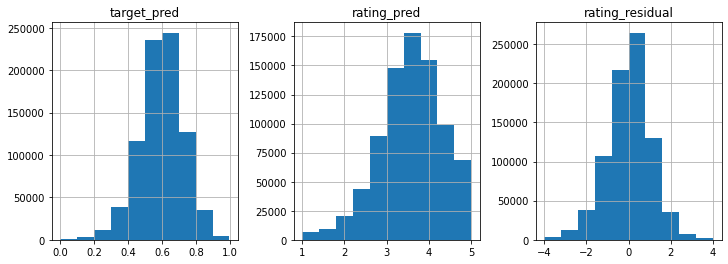

In [14]:
# distribution of residuals
df_res[['target_pred', 'rating_pred', 'rating_residual']].hist(figsize=(12,4), layout=(1,3))
plt.show()